In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
sns.set()
%matplotlib inline

# Data 

In [2]:
FolderNames = ["BoulangeriePatisserie", "GlacesSorbets", "Fromage", "Electricite","Trefilage"]

df = pd.read_csv(
   "./{}/valeurs_mensuelles.csv".format(FolderNames[0]),
    sep=";",
    skiprows=[1, 2],
    index_col="Libellé",
    parse_dates=["Libellé"])
df.columns = [FolderNames[0],"ToDelete"]
del(df["ToDelete"])


for i,name in enumerate(FolderNames):
    if i>0:
        temp = pd.read_csv(
       "./{}/valeurs_mensuelles.csv".format(name),
        sep=";",
        skiprows=[1, 2],
        index_col="Libellé",
        parse_dates=["Libellé"])
        temp.columns = [FolderNames[i],"ToDelete"]
        del(temp["ToDelete"])
        df = pd.merge(df, temp, on='Libellé')
    
df.head()


,BoulangeriePatisserie,GlacesSorbets,Fromage,Electricite,Trefilage
Libellé,,,,,
2019-01-01,104.01,87.15,98.24,141.17,79.42
2018-12-01,95.64,37.26,95.97,123.86,55.01
2018-11-01,102.27,59.06,97.25,111.67,80.52
2018-10-01,111.41,65.15,98.34,91.65,87.86
2018-09-01,99.68,77.15,90.37,79.35,75.64


# Plots

Les indices de dates sont les mêmes, on peut donc merger les 5 séries sur les dates.

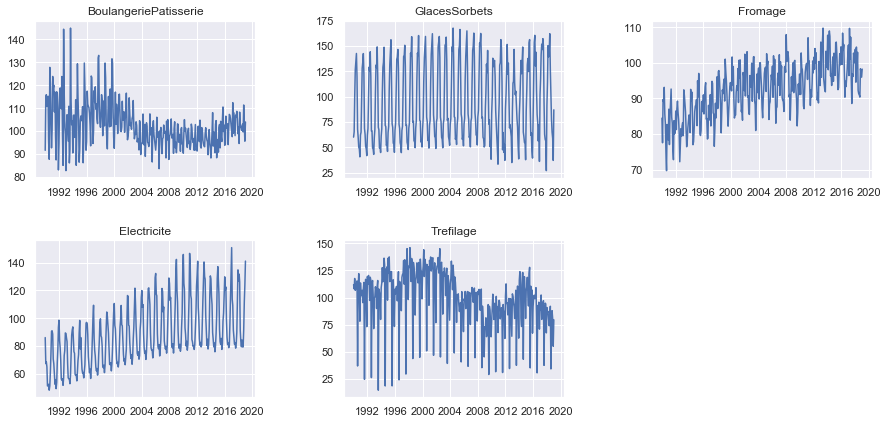

In [3]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i,name in enumerate(FolderNames):
    
    X = df.iloc[:,i].dropna()
    ax = fig.add_subplot(4, 3, i+1)
    ax.plot(X)
    ax.set(title=name)

On garde la série de la production industrielle de tréfilage à froid. Pas vraiment de tendance monotone mais un saisonalité certaine.

# Tréfilage à froid

In [4]:
dfT = pd.read_csv(
   "./Trefilage/valeurs_mensuelles.csv",
    sep=";",
    skiprows=[1, 2],
    index_col="Libellé",
    parse_dates=["Libellé"])
dfT.columns = ["Trefilage","ToDelete"]
del(dfT["ToDelete"])

In [5]:
len(dfT)
#12*(2019-1990)+2

350

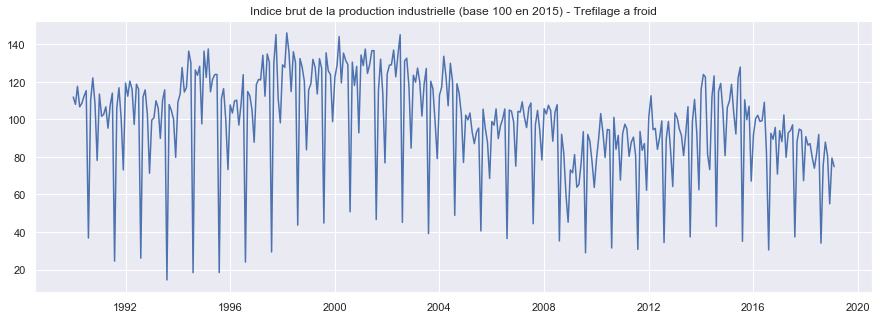

In [6]:
plt.figure(figsize=(15,5))
plt.plot(dfT)
plt.title("Indice brut de la production industrielle (base 100 en 2015) - Trefilage a froid")
plt.show()

## Transformation logarithmique

In [7]:
log_dfT = np.log(dfT)

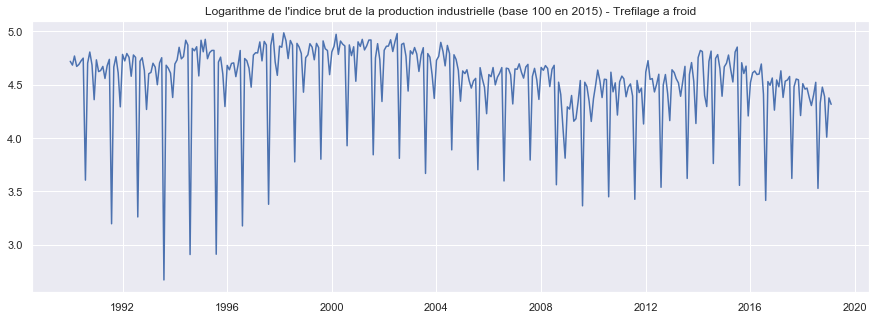

In [8]:
plt.figure(figsize=(15,5))
plt.plot(log_dfT)
plt.title("Logarithme de l'indice brut de la production industrielle (base 100 en 2015) - Trefilage a froid")
plt.show()

**Commentaires:** La transformation logarithmique permet de corriger certaines formes d'hétéroscédasticité ou de non-linéarité. Dans notre cas, notre série était légèrement hétéroscédastique et la transformation logarithmique ne l'a pas totalement corrigée.<br><br>

On travaillera cependant sur  la transformation logarithmique.

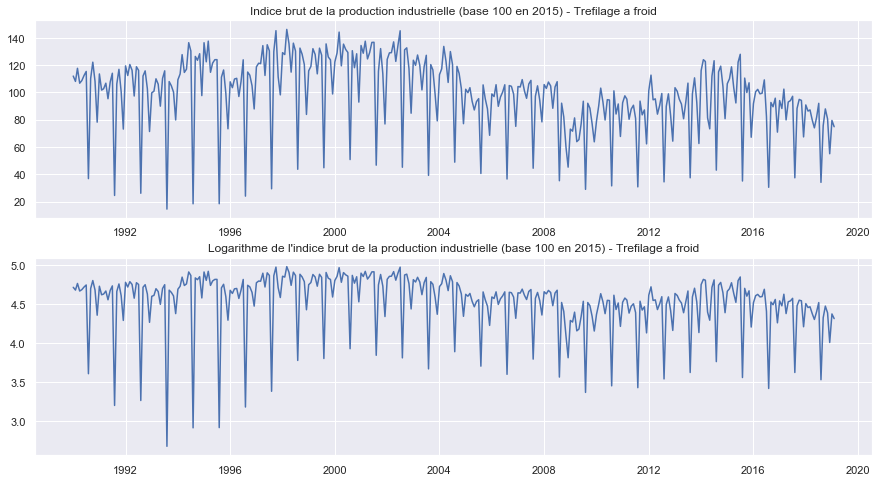

In [9]:
plt.figure(figsize=(15,8))

plt.subplot(2, 1, 1)
plt.plot(dfT)
plt.title("Indice brut de la production industrielle (base 100 en 2015) - Trefilage a froid")
#plt.ylabel, plt/xlabel

plt.subplot(2, 1, 2)
plt.plot(log_dfT)
plt.title("Logarithme de l'indice brut de la production industrielle (base 100 en 2015) - Trefilage a froid")

#plt.savefig("donneesEtdonneesLog.png")

plt.show()

## ACF

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

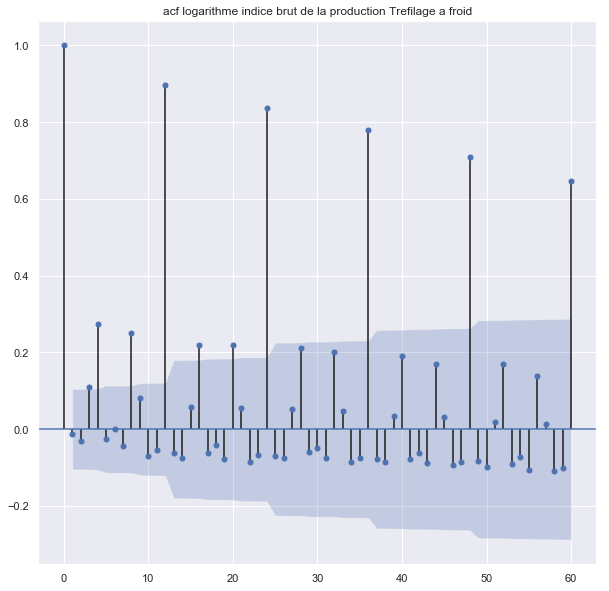

In [11]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(10,10))
    plot_acf(log_dfT, lags=60,
             title="acf logarithme indice brut de la production Trefilage a froid",
        )
    
#vrais intervals de confiance : bartlet's formula

**Commentaires:** On observe une saisonalité annuelle (pic tous les 12 mois).

## PACF

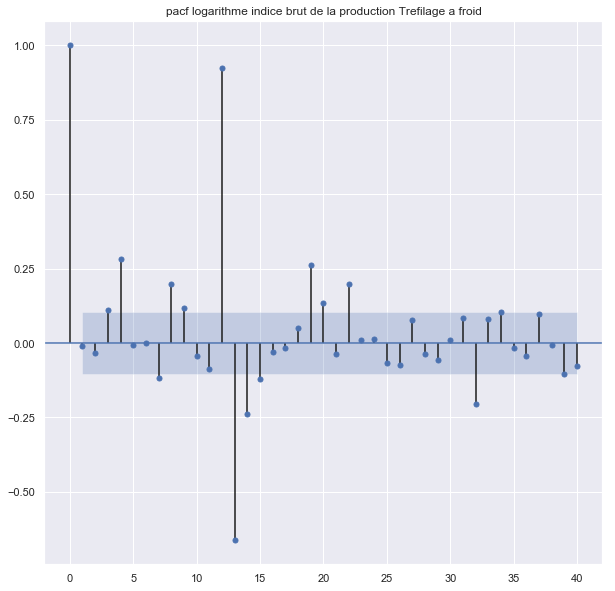

In [12]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(10,10))
    plot_pacf(log_dfT, lags=40,
             title="pacf logarithme indice brut de la production Trefilage a froid",
        )
#intervals de confiance standards

**Commentaires:** pas de soupcon de racine unitaire, pas de correlation forte entre $X_t$ et $X_{t-1}$.

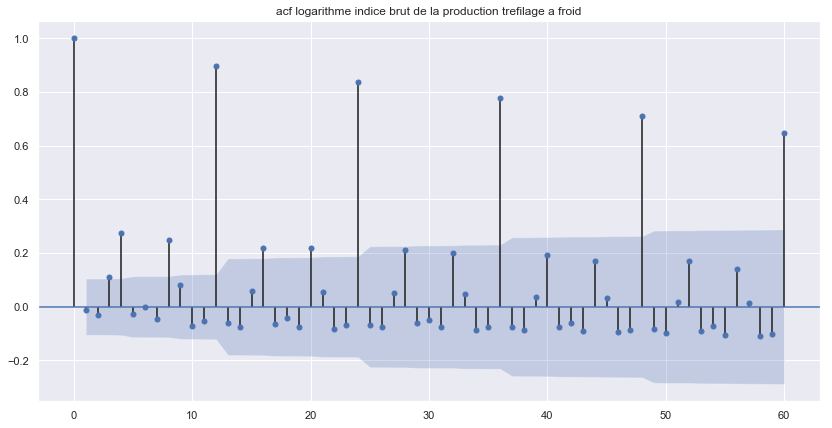

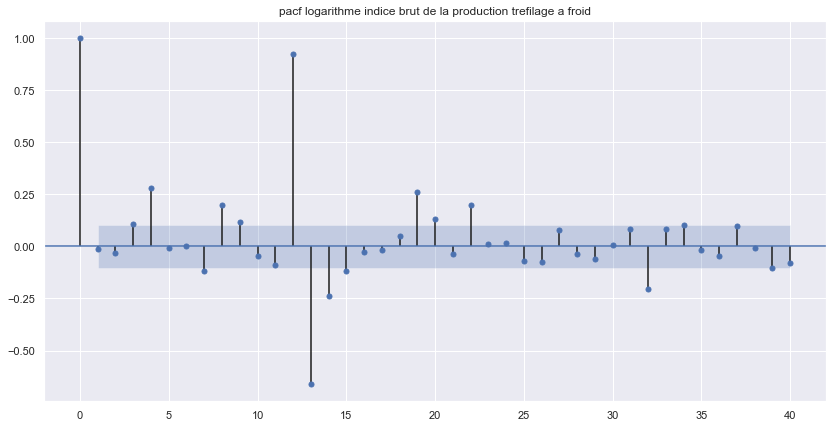

In [13]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))

    plot_acf(log_dfT, lags=60,
             title="acf logarithme indice brut de la production trefilage a froid")
    plt.savefig("Images/acf.png")

    plot_pacf(log_dfT, lags=40,
             title="pacf logarithme indice brut de la production trefilage a froid")
    plt.savefig("Images/pacf.png")

## Désaisonnalisation 

### Première méthode : différence 12ème 

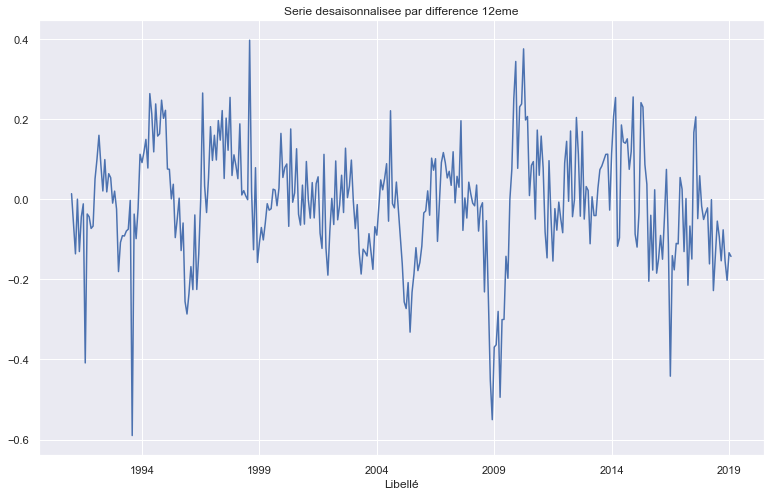

338

In [57]:
log_dfT_diff=log_dfT.diff(12).dropna()

log_dfT_diff.plot(title="Serie desaisonnalisee par difference 12eme", legend=False,figsize=(13,8))

plt.savefig("Images/DeSaison.png")

plt.show()

len(log_dfT_diff)

In [15]:
np.mean(log_dfT_diff)

Trefilage   -0.010824
dtype: float64

### 2ème méthode : régression avec des "dummy"

In [16]:
import statsmodels.api as sm

In [17]:
log_dfT.shape

(350, 1)

On régresse log_dfE sur les indicatrices de chaque mois : $$logdfE_t = \alpha + \sum_{i=11}^11 \beta_i \mathcal{1}_{mois_t=i} + \epsilon_t$$ $$Y = X'\beta + \epsilon$$ $X$ à spécifier (350*12)

In [18]:
X = np.tile(np.eye(12), 32).T[:350,:11]
X = sm.add_constant(X)
X = pd.DataFrame(X,index= log_dfT.index)
X.shape

(350, 12)

In [19]:
# On fait une régression par MCO du log du commerce d'électricité sur les dummy de mois (sauf 1 pour eviter le DV trap)
model = sm.OLS(log_dfT,X) 
results = model.fit()
DeSaison = results.resid # On récupère les résidus

In [20]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Trefilage   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     107.5
Date:                Mon, 22 Apr 2019   Prob (F-statistic):          3.16e-103
Time:                        17:40:12   Log-Likelihood:                 112.20
No. Observations:                 350   AIC:                            -200.4
Df Residuals:                     338   BIC:                            -154.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              4.3059      0.033    129.763      0.0

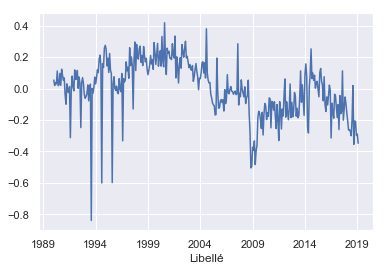

In [21]:
DeSaison.plot() # Reste la tendance

## Differenciation à l'ordre 1 pour stationnariser

###  1ere methode

In [54]:
station = log_dfT_diff.diff(1).dropna()
len(station)

337

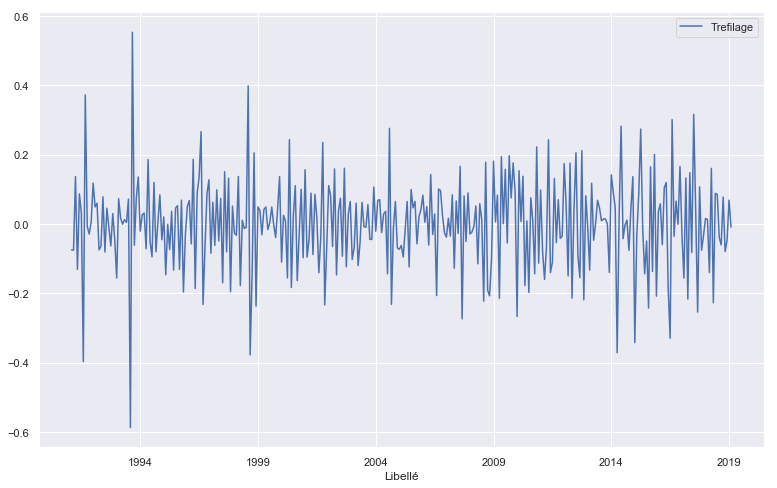

In [69]:
station.plot(figsize=(13,8))
plt.savefig("Images/DeSaison2.png")
plt.show()

Semble stationnaire. À confirmer avec des tests.

### 2eme methode

In [24]:
station2 = DeSaison.diff(1).dropna()

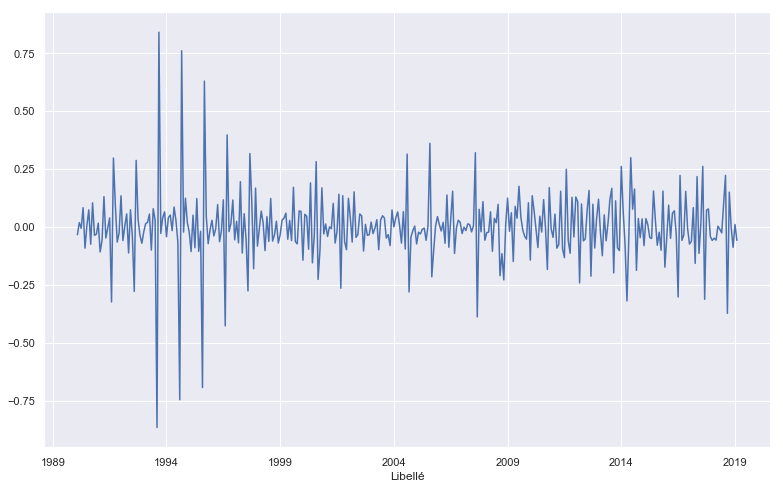

In [25]:
station2.plot(figsize=(13,8))

plt.show()

## ACF et PACF

### Difference 12eme 

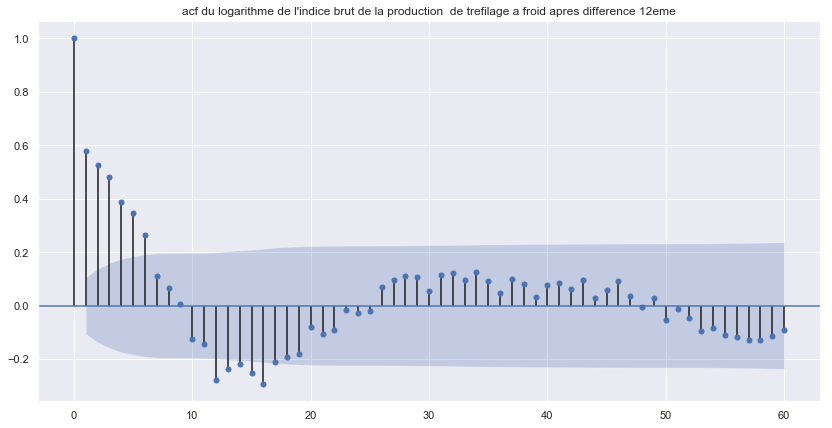

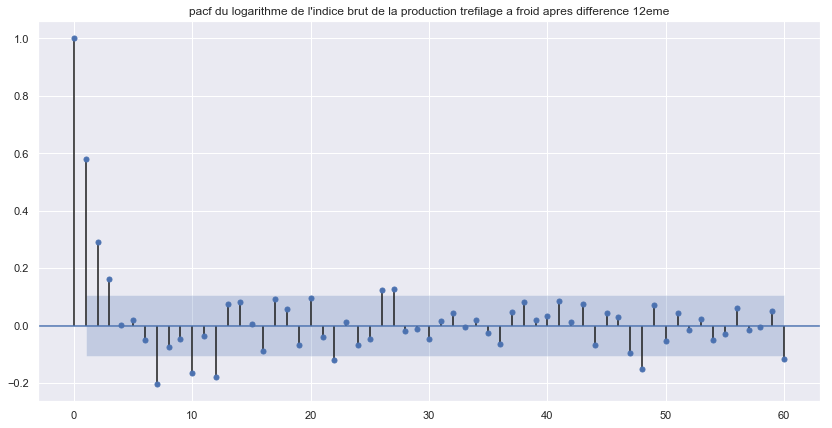

In [64]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))

    plot_acf(log_dfT_diff.values, lags=60,
             title="acf du logarithme de l'indice brut de la production  de trefilage a froid apres difference 12eme")
    #plt.savefig("Images/acf12eme.png")

    plot_pacf(log_dfT_diff.values, lags=60,
           title="pacf du logarithme de l'indice brut de la production trefilage a froid apres difference 12eme")
    #plt.savefig("Images/pacf12eme.png")

### Difference 12eme et 1ere

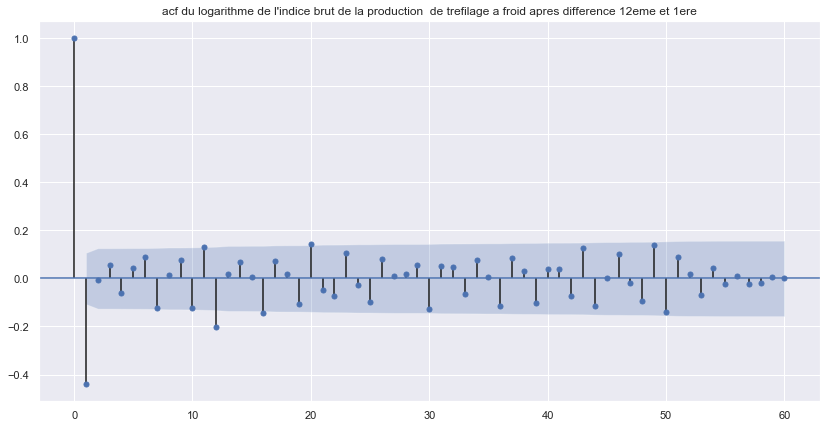

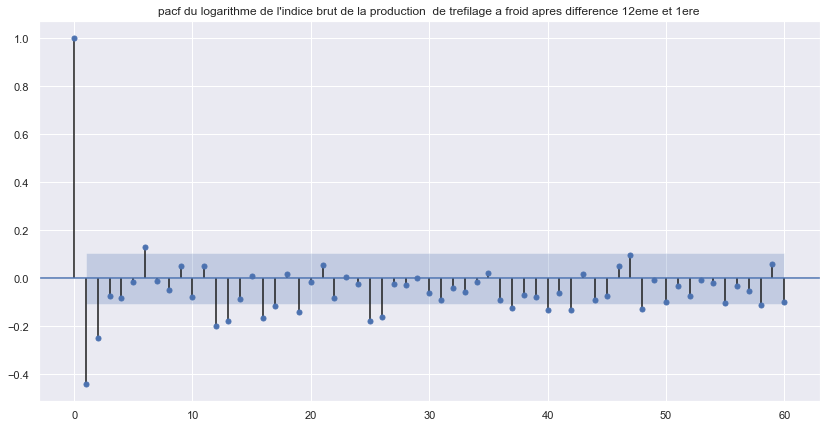

In [68]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))

    plot_acf(station.values, lags=60,
             title="acf du logarithme de l'indice brut de la production  de trefilage a froid apres difference 12eme et 1ere")
    plt.savefig("Images/acf12eme1ere.png")

    plot_pacf(station.values, lags=60,
        title="pacf du logarithme de l'indice brut de la production  de trefilage a froid apres difference 12eme et 1ere")
    plt.savefig("Images/pacf12eme1ere.png")

### Regression et difference 1ere

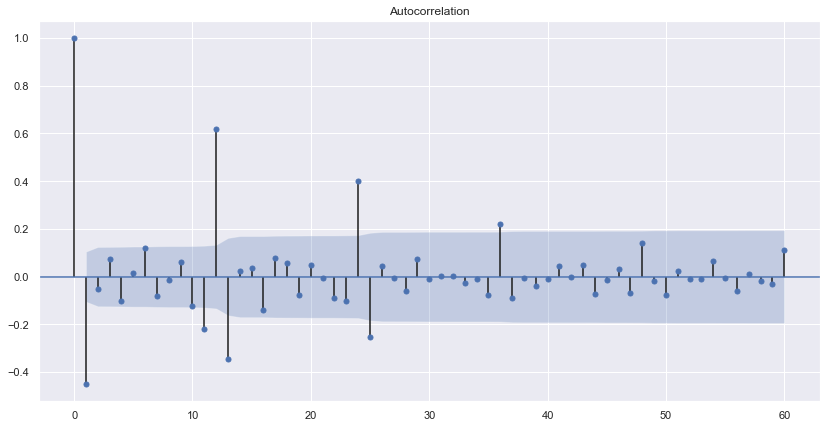

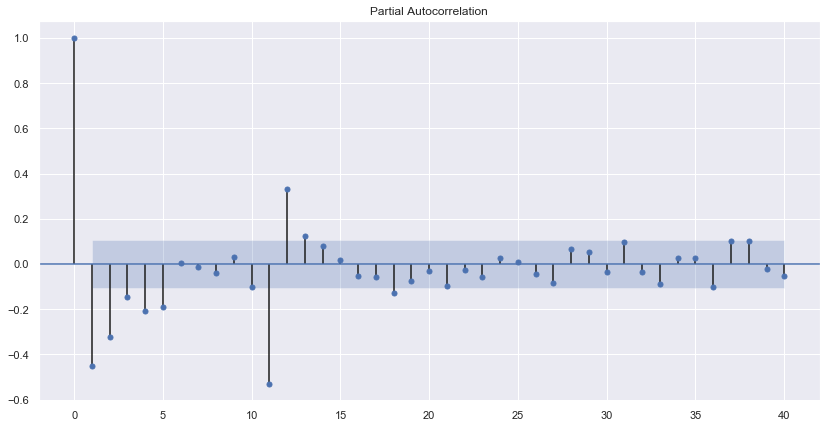

In [27]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(14,7))

    plot_acf(station2.values, lags=60)
             #title="acf logarithme indice brut de la production trefilage a froid")
    #plt.savefig("Images/acf.png")

    plot_pacf(station2.values, lags=40)
           # title="pacf logarithme indice brut de la production trefilage a froid")
    #plt.savefig("Images/pacf.png")

Moins convaincant, on garde la premiere methode.

## Test de racine unitaire

Valider nos transformations de données et vérifier la stationnarité.

### PP

In [50]:
from arch.unitroot import PhillipsPerron

In [51]:
#log
pp = PhillipsPerron(log_dfT.values)
pp.summary()

Test Statistic,-20.482
P-value,0.000
Lags,17


In [53]:
dfpp = pd.DataFrame({"PP Test":[pp.critical_values['1%'],pp.stat,pp.pvalue]},
             index = ["critical value (1%)","Test Statistic", "p value"] )
dfpp
print(dfpp.to_latex())

\begin{tabular}{lr}
\toprule
{} &    PP Test \\
\midrule
critical value (1\%) &  -3.449227 \\
Test Statistic      & -20.482009 \\
p value             &   0.000000 \\
\bottomrule
\end{tabular}



In [61]:
#log + difference 12
pp = PhillipsPerron(log_dfT_diff.values)
pp.summary()

Test Statistic,-10.421
P-value,0.000
Lags,17


In [30]:
pp = PhillipsPerron(station)
pp.summary()

Test Statistic,-40.769
P-value,0.000
Lags,17


In [31]:
pp = PhillipsPerron(station2)
pp.summary()

Test Statistic,-55.540
P-value,0.000
Lags,17


### Test de stationnarité : KPSS

In [32]:
from arch.unitroot import KPSS

In [42]:
kpss = KPSS(log_dfT)
kpss.summary()

0.0001

In [62]:
kpss = KPSS(log_dfT_diff)
kpss.summary()

Test Statistic,0.097
P-value,0.598
Lags,10


In [63]:
dfkpss = pd.DataFrame({"KPSS Test":[kpss.critical_values['1%'],kpss.stat,kpss.pvalue]},
             index = ["critical value (1%)","Test Statistic", "p value"] )
dfkpss
print(dfkpss.to_latex())

\begin{tabular}{lr}
\toprule
{} &  KPSS Test \\
\midrule
critical value (1\%) &   0.742800 \\
Test Statistic      &   0.097491 \\
p value             &   0.598047 \\
\bottomrule
\end{tabular}



In [34]:
kpss = KPSS(station)
kpss.summary()

Test Statistic,0.021
P-value,0.995
Lags,14


In [35]:
kpss = KPSS(station2)
kpss.summary()

Test Statistic,0.082
P-value,0.680
Lags,22


## Conclusion

On garde "station" : difference 12eme + difference 1ere qui passe les tests de stationnarité et de racine unitaire.
"station 2" passe aussi les tests mais on ne la garde pas, les acf et pacf ne sont pas concluants.

In [36]:
import os

In [37]:
station.to_csv("Trefilage/stationnaire.csv")

In [72]:
kpss = KPSS(station)
pp = PhillipsPerron(station)
dftests = pd.DataFrame({"KPSS Test":[kpss.critical_values['1%'],kpss.stat,kpss.pvalue],
                       "PP Test":[pp.critical_values['1%'],pp.stat,pp.pvalue]},
             index = ["critical value (1%)","Test Statistic", "p value"] )
dftests
print(dftests.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  KPSS Test &    PP Test \\
\midrule
critical value (1\%) &   0.742800 &  -3.449963 \\
Test Statistic      &   0.021106 & -40.769299 \\
p value             &   0.995181 &   0.000000 \\
\bottomrule
\end{tabular}



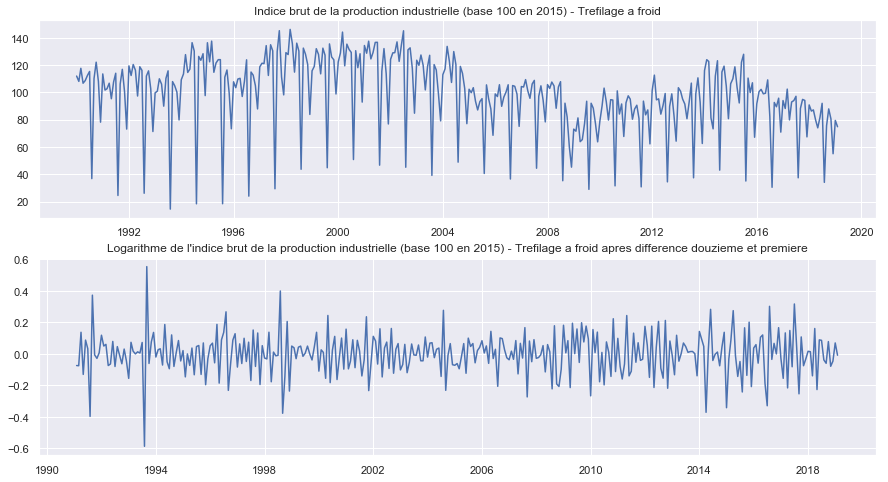

In [74]:
plt.figure(figsize=(15,8))

plt.subplot(2, 1, 1)
plt.plot(dfT)
plt.title("Indice brut de la production industrielle (base 100 en 2015) - Trefilage a froid")
#plt.ylabel, plt/xlabel

plt.subplot(2, 1, 2)
plt.plot(station)
plt.title("Logarithme de l'indice brut de la production industrielle (base 100 en 2015) - Trefilage a froid apres difference douzieme et premiere")

plt.savefig("reprgraphique.png")

plt.show()